## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn           as sb
import scipy.stats       as sp

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(777)

스케일러 라이브러리

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import joblib

## 데이터 불러오기

In [4]:
inputdata = pd.read_csv('./input-test1.csv',skiprows = 6, sep=',')
inputdata

,Name,P1,P2,P3,P4,P5,P6,P7,P8,P10
0,DP 0,80,120.0,110.0,100.0,98.0,85.0,80.0,80.0,0.002414
1,DP 1,80,80.2,105.4,103.8,114.2,82.2,99.8,100.6,0.002639
2,DP 2,80,80.6,83.8,97.0,105.8,86.2,113.4,81.8,0.002597
3,DP 3,80,81.0,93.8,115.0,118.6,105.4,98.2,98.6,0.002549
4,DP 4,80,81.4,107.8,87.4,98.6,108.2,87.8,91.8,0.002536
...,...,...,...,...,...,...,...,...,...,...
96,DP 96,80,118.2,108.2,116.6,117.0,106.2,94.6,82.6,0.002395
97,DP 97,80,118.6,109.8,80.6,109.8,107.0,99.4,94.2,0.002536
98,DP 98,80,119.0,104.6,109.8,111.0,89.4,93.0,97.0,0.002611
99,DP 99,80,119.4,80.6,100.2,119.4,109.8,109.4,89.8,0.002535


In [5]:
inputLabel = pd.read_csv('./ANN_Label/Mm_Label.csv', sep=',')
inputLabel

,Unnamed: 0,P10
0,0,0.001040
1,1,0.001311
2,2,0.000507
3,3,0.000756
4,4,0.000944
...,...,...
95,95,0.000798
96,96,0.001372
97,97,0.000753
98,98,0.000793


# training, label 분리

In [6]:
TrainData = inputdata.iloc[1:,1:-1]

TrainLabel_ = inputLabel.iloc[:,1]

In [7]:
pd.set_option('display.max_rows',10)
TrainData

,P1,P2,P3,P4,P5,P6,P7,P8
1,80,80.2,105.4,103.8,114.2,82.2,99.8,100.6
2,80,80.6,83.8,97.0,105.8,86.2,113.4,81.8
3,80,81.0,93.8,115.0,118.6,105.4,98.2,98.6
4,80,81.4,107.8,87.4,98.6,108.2,87.8,91.8
5,80,81.8,85.4,107.8,97.0,119.0,83.0,94.6
...,...,...,...,...,...,...,...,...
96,80,118.2,108.2,116.6,117.0,106.2,94.6,82.6
97,80,118.6,109.8,80.6,109.8,107.0,99.4,94.2
98,80,119.0,104.6,109.8,111.0,89.4,93.0,97.0
99,80,119.4,80.6,100.2,119.4,109.8,109.4,89.8


In [8]:
pd.DataFrame(TrainLabel_)

,P10
0,0.001040
1,0.001311
2,0.000507
3,0.000756
4,0.000944
...,...
95,0.000798
96,0.001372
97,0.000753
98,0.000793


In [9]:
max_value = np.max(TrainLabel_)
min_value = np.min(TrainLabel_)

dist_value = max_value - min_value

TrainLabel = ((TrainLabel_ - min_value)/dist_value)+0.5

In [10]:
pd.set_option("Display.max_rows",10)
pd.DataFrame(TrainLabel)

,P10
0,1.023719
1,1.290194
2,0.500000
3,0.744154
4,0.929545
...,...
95,0.785107
96,1.349925
97,0.741530
98,0.780506


## ANN hyperparameter 조절에 따른 학습성능 확인 

#### 지정 iteration마다 학습과정 확인 함수(Class) 정의

In [11]:
EpochForPrint = 100

class AccuracyPerEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keras.callbacks.Callback()
        if epoch%EpochForPrint == 0:
            print("[{} Epochs]    RMSE:{:.5f},   MAE: {:.5f},  MAPE: {:.2f}%"
                  .format(epoch, np.sqrt(logs['mse']), logs['mae'], logs['mape']))

#### Hyperparameter 조합 설정

In [12]:
# 조정 하이퍼파라미터 : 학습율, 은닉층 뉴런 수
Lr = [0.001, 0.005, 0.01]   # Learning Rates
N1 = [30, 40, 50, 60, 70]   # Number of Neurons on Hidden Layer 1
N2 = [10, 20, 30]           # Number of Neurons on Hidden Layer 2

Model = ['thickness']

# 고정 하이퍼파라미터 : 입력/출력층 뉴런 수, 학습 Epoch 수
noOfNeuron_in  = 50
noOfNeuron_out = 1
Epoch          = 5000

print('Number of case : %d'%(len(Lr)*len(N1)*len(N2)))

Number of case : 45


### 모델 학습 1 - FFT 특징 기반 Wn1, Wn2, R1, R2 예측

In [50]:
for M in range(1):
    
    Tr_result_temp = np.zeros((len(Lr)*len(N1)*len(N2) , 7)) # *len(N2)
    cnt = 0
    
#     exec('Label_Trn = TrainLabel_%d'%(M+1))
    print('\n\n\n\n################## Model %d (Predict :'%(M+1) + Model[M] + ') ##################')

    for i in range(len(Lr)):
        learningRate = Lr[i]

        for j in range(len(N1)):
            noOfNeuron1 = N1[j]
            
            for k in range(len(N2)):
                noOfNeuron2 = N2[k]

                print('\n\nTrial No.%d'%(cnt+1))
                print('Prediction :' + Model[M])
                print('Learning rate : {:.3}'.format(learningRate))
                print('Hidden 1 neuron : %d'%(noOfNeuron1))
                print('Hidden 2 neuron : %d'%(noOfNeuron2))

                ################ 신경망 구조 재설계 ################

                tf.keras.backend.clear_session()
                def ANN_model(input_data):
                    model = keras.Sequential()
                    model.add(keras.layers.Dense(units = noOfNeuron_in,
                                                 input_shape = (input_data.shape[1],), activation = 'relu'))  # Input  Layer
                    model.add(keras.layers.Dense(units = noOfNeuron1,                  activation = 'relu'))  # Hidden Layer 1
                    model.add(keras.layers.Dense(units = noOfNeuron2,                  activation = 'relu'))  # Hidden Layer 2
                    model.add(keras.layers.Dense(units = noOfNeuron_out,             )) # Output Layer
                    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                                  loss=keras.losses.mean_absolute_error,
                                  metrics=['mse','mae','mape'])
                    return model
                model = ANN_model(TrainData)

                ################ 신경망 학습 ################

                hist = model.fit(TrainData, TrainLabel, epochs=Epoch, verbose=0, callbacks=[AccuracyPerEpoch()], batch_size=100)
                print("\n[Final Epochs]    RMSE:{:.5f},   MAE: {:.5f},  MAPE: {:.2f}%"
                      .format(np.sqrt(hist.history['mse'][-1]), hist.history['mae'][-1], hist.history['mape'][-1]))
                
                model.save('D:/testoneblow/ANN_prediction2.0/slope label/MLmodels_epoch%d/Model_%d.h5'%(Epoch, cnt+1))
                
                Tr_result_temp[cnt,0] = cnt+1
                Tr_result_temp[cnt,1] = learningRate
                Tr_result_temp[cnt,2] = noOfNeuron1
                Tr_result_temp[cnt,3] = noOfNeuron2
                Tr_result_temp[cnt,4] = np.sqrt(hist.history['mse'][-1])
                Tr_result_temp[cnt,5] = hist.history['mae'][-1]
                Tr_result_temp[cnt,6] = hist.history['mape'][-1]

                cnt=cnt+1


    Tr_result_temp_pd = pd.DataFrame(Tr_result_temp, columns=['Case', 'L.rate', 'Nr-HL1', 'Nr-HL2', 'RMSE', 'MAE', 'MAPE'])
    Tr_result_temp_pd.to_csv('D:/testoneblow/ANN_prediction2.0/slope label/Tr_result_epoch%d.csv'%(Epoch), index=None)





################## Model 1 (Predict :thickness) ##################


Trial No.1
Prediction :thickness
Learning rate : 0.001
Hidden 1 neuron : 30
Hidden 2 neuron : 10
[0 Epochs]    RMSE:26.82626,   MAE: 26.76973,  MAPE: 3171.17%
[100 Epochs]    RMSE:0.30457,   MAE: 0.22409,  MAPE: 27.35%
[200 Epochs]    RMSE:0.22186,   MAE: 0.16585,  MAPE: 20.54%
[300 Epochs]    RMSE:0.17753,   MAE: 0.14175,  MAPE: 16.85%
[400 Epochs]    RMSE:0.19249,   MAE: 0.15454,  MAPE: 19.82%
[500 Epochs]    RMSE:0.20249,   MAE: 0.16554,  MAPE: 18.09%
[600 Epochs]    RMSE:0.14352,   MAE: 0.11383,  MAPE: 14.19%
[700 Epochs]    RMSE:0.16109,   MAE: 0.13392,  MAPE: 17.01%
[800 Epochs]    RMSE:0.12614,   MAE: 0.09733,  MAPE: 11.45%
[900 Epochs]    RMSE:0.14577,   MAE: 0.10702,  MAPE: 11.84%
[1000 Epochs]    RMSE:0.36995,   MAE: 0.34966,  MAPE: 39.63%
[1100 Epochs]    RMSE:0.11974,   MAE: 0.09685,  MAPE: 12.00%
[1200 Epochs]    RMSE:0.16873,   MAE: 0.14684,  MAPE: 18.57%
[1300 Epochs]    RMSE:0.11844,   MAE: 0.08811

[2900 Epochs]    RMSE:0.18014,   MAE: 0.16491,  MAPE: 18.58%
[3000 Epochs]    RMSE:0.10727,   MAE: 0.08500,  MAPE: 10.74%
[3100 Epochs]    RMSE:0.10985,   MAE: 0.08747,  MAPE: 11.06%
[3200 Epochs]    RMSE:0.11342,   MAE: 0.09116,  MAPE: 11.49%
[3300 Epochs]    RMSE:0.07148,   MAE: 0.05585,  MAPE: 6.48%
[3400 Epochs]    RMSE:0.07076,   MAE: 0.05615,  MAPE: 6.47%
[3500 Epochs]    RMSE:0.12368,   MAE: 0.11125,  MAPE: 12.54%
[3600 Epochs]    RMSE:0.09861,   MAE: 0.07863,  MAPE: 9.91%
[3700 Epochs]    RMSE:0.06968,   MAE: 0.05267,  MAPE: 6.38%
[3800 Epochs]    RMSE:0.06989,   MAE: 0.05072,  MAPE: 6.31%
[3900 Epochs]    RMSE:0.06343,   MAE: 0.04720,  MAPE: 5.57%
[4000 Epochs]    RMSE:0.08812,   MAE: 0.07669,  MAPE: 8.74%
[4100 Epochs]    RMSE:0.14869,   MAE: 0.13491,  MAPE: 15.24%
[4200 Epochs]    RMSE:0.08657,   MAE: 0.07641,  MAPE: 8.73%
[4300 Epochs]    RMSE:0.08585,   MAE: 0.06637,  MAPE: 8.28%
[4400 Epochs]    RMSE:0.11140,   MAE: 0.09434,  MAPE: 11.75%
[4500 Epochs]    RMSE:0.08060,   

[800 Epochs]    RMSE:0.10776,   MAE: 0.08382,  MAPE: 9.49%
[900 Epochs]    RMSE:0.12627,   MAE: 0.10234,  MAPE: 11.29%
[1000 Epochs]    RMSE:0.10112,   MAE: 0.07989,  MAPE: 9.90%
[1100 Epochs]    RMSE:0.08574,   MAE: 0.06539,  MAPE: 7.84%
[1200 Epochs]    RMSE:0.10078,   MAE: 0.08052,  MAPE: 10.01%
[1300 Epochs]    RMSE:0.13053,   MAE: 0.11057,  MAPE: 13.90%
[1400 Epochs]    RMSE:0.10058,   MAE: 0.08074,  MAPE: 9.13%
[1500 Epochs]    RMSE:0.13006,   MAE: 0.11109,  MAPE: 13.88%
[1600 Epochs]    RMSE:0.10205,   MAE: 0.08403,  MAPE: 10.49%
[1700 Epochs]    RMSE:0.13403,   MAE: 0.11727,  MAPE: 13.30%
[1800 Epochs]    RMSE:0.08556,   MAE: 0.06742,  MAPE: 8.31%
[1900 Epochs]    RMSE:0.11658,   MAE: 0.09804,  MAPE: 12.28%
[2000 Epochs]    RMSE:0.08464,   MAE: 0.06844,  MAPE: 8.44%
[2100 Epochs]    RMSE:0.07296,   MAE: 0.06082,  MAPE: 7.19%
[2200 Epochs]    RMSE:0.22641,   MAE: 0.20952,  MAPE: 23.82%
[2300 Epochs]    RMSE:0.07459,   MAE: 0.06117,  MAPE: 7.18%
[2400 Epochs]    RMSE:0.08221,   M

[4000 Epochs]    RMSE:0.10057,   MAE: 0.09010,  MAPE: 10.31%
[4100 Epochs]    RMSE:0.13753,   MAE: 0.12768,  MAPE: 14.76%
[4200 Epochs]    RMSE:0.09739,   MAE: 0.08487,  MAPE: 9.71%
[4300 Epochs]    RMSE:0.06766,   MAE: 0.05605,  MAPE: 6.81%
[4400 Epochs]    RMSE:0.06485,   MAE: 0.05491,  MAPE: 6.60%
[4500 Epochs]    RMSE:0.10139,   MAE: 0.09365,  MAPE: 11.30%
[4600 Epochs]    RMSE:0.08142,   MAE: 0.07054,  MAPE: 8.59%
[4700 Epochs]    RMSE:0.10522,   MAE: 0.09714,  MAPE: 11.79%
[4800 Epochs]    RMSE:0.07503,   MAE: 0.06404,  MAPE: 7.84%
[4900 Epochs]    RMSE:0.05675,   MAE: 0.04638,  MAPE: 5.21%

[Final Epochs]    RMSE:0.10900,   MAE: 0.10147,  MAPE: 11.71%


Trial No.9
Prediction :thickness
Learning rate : 0.001
Hidden 1 neuron : 50
Hidden 2 neuron : 30
[0 Epochs]    RMSE:7.84497,   MAE: 7.33227,  MAPE: 878.32%
[100 Epochs]    RMSE:0.36744,   MAE: 0.24280,  MAPE: 27.82%
[200 Epochs]    RMSE:0.62652,   MAE: 0.56295,  MAPE: 64.23%
[300 Epochs]    RMSE:0.20204,   MAE: 0.13683,  MAPE: 16

[1800 Epochs]    RMSE:0.14563,   MAE: 0.13245,  MAPE: 15.15%
[1900 Epochs]    RMSE:0.07154,   MAE: 0.04783,  MAPE: 5.47%
[2000 Epochs]    RMSE:0.06759,   MAE: 0.04470,  MAPE: 5.04%
[2100 Epochs]    RMSE:0.07717,   MAE: 0.05619,  MAPE: 6.28%
[2200 Epochs]    RMSE:0.07831,   MAE: 0.06417,  MAPE: 7.76%
[2300 Epochs]    RMSE:0.06070,   MAE: 0.03590,  MAPE: 4.13%
[2400 Epochs]    RMSE:0.16323,   MAE: 0.14783,  MAPE: 16.89%
[2500 Epochs]    RMSE:0.05848,   MAE: 0.03540,  MAPE: 4.15%
[2600 Epochs]    RMSE:0.06126,   MAE: 0.04328,  MAPE: 5.23%
[2700 Epochs]    RMSE:0.08616,   MAE: 0.07252,  MAPE: 8.87%
[2800 Epochs]    RMSE:0.05697,   MAE: 0.03604,  MAPE: 4.09%
[2900 Epochs]    RMSE:0.06810,   MAE: 0.05202,  MAPE: 6.27%
[3000 Epochs]    RMSE:0.09121,   MAE: 0.07590,  MAPE: 8.57%
[3100 Epochs]    RMSE:0.05509,   MAE: 0.03460,  MAPE: 3.97%
[3200 Epochs]    RMSE:0.05440,   MAE: 0.03557,  MAPE: 4.25%
[3300 Epochs]    RMSE:0.05247,   MAE: 0.03477,  MAPE: 4.16%
[3400 Epochs]    RMSE:0.05042,   MAE: 

[4800 Epochs]    RMSE:0.14336,   MAE: 0.12508,  MAPE: 14.37%
[4900 Epochs]    RMSE:0.07783,   MAE: 0.06372,  MAPE: 7.54%

[Final Epochs]    RMSE:0.06653,   MAE: 0.05427,  MAPE: 6.61%


Trial No.14
Prediction :thickness
Learning rate : 0.001
Hidden 1 neuron : 70
Hidden 2 neuron : 20
[0 Epochs]    RMSE:62.86829,   MAE: 62.77248,  MAPE: 7432.00%
[100 Epochs]    RMSE:0.25093,   MAE: 0.18306,  MAPE: 19.72%
[200 Epochs]    RMSE:0.53068,   MAE: 0.49699,  MAPE: 62.81%
[300 Epochs]    RMSE:0.27310,   MAE: 0.23395,  MAPE: 30.48%
[400 Epochs]    RMSE:0.30834,   MAE: 0.26767,  MAPE: 34.90%
[500 Epochs]    RMSE:0.16604,   MAE: 0.12587,  MAPE: 14.69%
[600 Epochs]    RMSE:0.15995,   MAE: 0.11898,  MAPE: 14.08%
[700 Epochs]    RMSE:0.15932,   MAE: 0.11834,  MAPE: 12.95%
[800 Epochs]    RMSE:0.13487,   MAE: 0.10039,  MAPE: 11.57%
[900 Epochs]    RMSE:0.11836,   MAE: 0.09519,  MAPE: 11.22%
[1000 Epochs]    RMSE:0.24465,   MAE: 0.21758,  MAPE: 23.82%
[1100 Epochs]    RMSE:0.25052,   MAE: 0.21761,  MAPE: 

[2600 Epochs]    RMSE:0.04378,   MAE: 0.03111,  MAPE: 3.82%
[2700 Epochs]    RMSE:0.04897,   MAE: 0.03506,  MAPE: 4.32%
[2800 Epochs]    RMSE:0.07294,   MAE: 0.06560,  MAPE: 7.39%
[2900 Epochs]    RMSE:0.04158,   MAE: 0.02874,  MAPE: 3.65%
[3000 Epochs]    RMSE:0.04391,   MAE: 0.03435,  MAPE: 4.25%
[3100 Epochs]    RMSE:0.04136,   MAE: 0.03144,  MAPE: 3.71%
[3200 Epochs]    RMSE:0.04883,   MAE: 0.03837,  MAPE: 4.76%
[3300 Epochs]    RMSE:0.06692,   MAE: 0.05761,  MAPE: 6.88%
[3400 Epochs]    RMSE:0.04077,   MAE: 0.03162,  MAPE: 3.90%
[3500 Epochs]    RMSE:0.03427,   MAE: 0.02562,  MAPE: 3.15%
[3600 Epochs]    RMSE:0.04561,   MAE: 0.03759,  MAPE: 4.31%
[3700 Epochs]    RMSE:0.04314,   MAE: 0.03239,  MAPE: 3.85%
[3800 Epochs]    RMSE:0.04150,   MAE: 0.03398,  MAPE: 3.94%
[3900 Epochs]    RMSE:0.03840,   MAE: 0.03080,  MAPE: 3.65%
[4000 Epochs]    RMSE:0.04606,   MAE: 0.03913,  MAPE: 4.45%
[4100 Epochs]    RMSE:0.04966,   MAE: 0.03127,  MAPE: 3.81%
[4200 Epochs]    RMSE:0.02871,   MAE: 0.

[600 Epochs]    RMSE:0.15098,   MAE: 0.10751,  MAPE: 12.45%
[700 Epochs]    RMSE:0.14073,   MAE: 0.09809,  MAPE: 10.82%
[800 Epochs]    RMSE:0.12009,   MAE: 0.08502,  MAPE: 9.61%
[900 Epochs]    RMSE:0.16191,   MAE: 0.13124,  MAPE: 14.02%
[1000 Epochs]    RMSE:0.10181,   MAE: 0.07554,  MAPE: 8.34%
[1100 Epochs]    RMSE:0.09372,   MAE: 0.07691,  MAPE: 9.33%
[1200 Epochs]    RMSE:0.07668,   MAE: 0.06121,  MAPE: 7.31%
[1300 Epochs]    RMSE:0.06782,   MAE: 0.05428,  MAPE: 6.44%
[1400 Epochs]    RMSE:0.08757,   MAE: 0.07137,  MAPE: 8.91%
[1500 Epochs]    RMSE:0.08988,   MAE: 0.07333,  MAPE: 8.01%
[1600 Epochs]    RMSE:0.07014,   MAE: 0.05499,  MAPE: 6.74%
[1700 Epochs]    RMSE:0.06907,   MAE: 0.05366,  MAPE: 6.62%
[1800 Epochs]    RMSE:0.06004,   MAE: 0.04855,  MAPE: 5.76%
[1900 Epochs]    RMSE:0.07982,   MAE: 0.06654,  MAPE: 7.53%
[2000 Epochs]    RMSE:0.06349,   MAE: 0.05042,  MAPE: 5.82%
[2100 Epochs]    RMSE:0.05733,   MAE: 0.04321,  MAPE: 5.28%
[2200 Epochs]    RMSE:0.07415,   MAE: 0.0

[3800 Epochs]    RMSE:0.03186,   MAE: 0.02485,  MAPE: 2.85%
[3900 Epochs]    RMSE:0.03347,   MAE: 0.02643,  MAPE: 3.21%
[4000 Epochs]    RMSE:0.03351,   MAE: 0.02682,  MAPE: 3.16%
[4100 Epochs]    RMSE:0.04507,   MAE: 0.03884,  MAPE: 4.33%
[4200 Epochs]    RMSE:0.04507,   MAE: 0.03517,  MAPE: 3.73%
[4300 Epochs]    RMSE:0.05932,   MAE: 0.04597,  MAPE: 4.97%
[4400 Epochs]    RMSE:0.03451,   MAE: 0.02830,  MAPE: 3.31%
[4500 Epochs]    RMSE:0.01831,   MAE: 0.01436,  MAPE: 1.62%
[4600 Epochs]    RMSE:0.05167,   MAE: 0.04210,  MAPE: 4.75%
[4700 Epochs]    RMSE:0.02168,   MAE: 0.01677,  MAPE: 1.92%
[4800 Epochs]    RMSE:0.02247,   MAE: 0.01797,  MAPE: 2.11%
[4900 Epochs]    RMSE:0.02269,   MAE: 0.01785,  MAPE: 2.15%

[Final Epochs]    RMSE:0.02669,   MAE: 0.02057,  MAPE: 2.50%


Trial No.22
Prediction :thickness
Learning rate : 0.005
Hidden 1 neuron : 50
Hidden 2 neuron : 10
[0 Epochs]    RMSE:5.06402,   MAE: 4.74781,  MAPE: 564.95%
[100 Epochs]    RMSE:0.21878,   MAE: 0.16370,  MAPE: 17.85%

[1800 Epochs]    RMSE:0.12270,   MAE: 0.10428,  MAPE: 11.64%
[1900 Epochs]    RMSE:0.05487,   MAE: 0.04004,  MAPE: 4.56%
[2000 Epochs]    RMSE:0.05714,   MAE: 0.04421,  MAPE: 4.93%
[2100 Epochs]    RMSE:0.05371,   MAE: 0.04139,  MAPE: 4.84%
[2200 Epochs]    RMSE:0.08536,   MAE: 0.06856,  MAPE: 8.17%
[2300 Epochs]    RMSE:0.05095,   MAE: 0.03894,  MAPE: 4.58%
[2400 Epochs]    RMSE:0.04090,   MAE: 0.02870,  MAPE: 3.30%
[2500 Epochs]    RMSE:0.03842,   MAE: 0.02819,  MAPE: 3.19%
[2600 Epochs]    RMSE:0.07575,   MAE: 0.06226,  MAPE: 7.26%
[2700 Epochs]    RMSE:0.05226,   MAE: 0.04172,  MAPE: 4.88%
[2800 Epochs]    RMSE:0.04028,   MAE: 0.03267,  MAPE: 3.82%
[2900 Epochs]    RMSE:0.04048,   MAE: 0.03283,  MAPE: 3.71%
[3000 Epochs]    RMSE:0.03314,   MAE: 0.02379,  MAPE: 2.76%
[3100 Epochs]    RMSE:0.05590,   MAE: 0.04870,  MAPE: 5.66%
[3200 Epochs]    RMSE:0.09798,   MAE: 0.08683,  MAPE: 10.01%
[3300 Epochs]    RMSE:0.03085,   MAE: 0.02290,  MAPE: 2.74%
[3400 Epochs]    RMSE:0.03165,   MAE: 


[Final Epochs]    RMSE:0.02627,   MAE: 0.02156,  MAPE: 2.62%


Trial No.27
Prediction :thickness
Learning rate : 0.005
Hidden 1 neuron : 60
Hidden 2 neuron : 30
[0 Epochs]    RMSE:29.08678,   MAE: 28.95731,  MAPE: 3444.99%
[100 Epochs]    RMSE:2.17138,   MAE: 2.15085,  MAPE: 259.31%
[200 Epochs]    RMSE:0.35211,   MAE: 0.30400,  MAPE: 32.58%
[300 Epochs]    RMSE:0.15354,   MAE: 0.12421,  MAPE: 14.94%
[400 Epochs]    RMSE:0.16654,   MAE: 0.13502,  MAPE: 16.32%
[500 Epochs]    RMSE:0.11201,   MAE: 0.08118,  MAPE: 8.76%
[600 Epochs]    RMSE:0.10142,   MAE: 0.07877,  MAPE: 8.78%
[700 Epochs]    RMSE:0.12852,   MAE: 0.11032,  MAPE: 12.15%
[800 Epochs]    RMSE:0.07793,   MAE: 0.06265,  MAPE: 6.99%
[900 Epochs]    RMSE:0.11645,   MAE: 0.10184,  MAPE: 12.57%
[1000 Epochs]    RMSE:0.07252,   MAE: 0.05744,  MAPE: 6.42%
[1100 Epochs]    RMSE:0.05523,   MAE: 0.04159,  MAPE: 4.67%
[1200 Epochs]    RMSE:0.05183,   MAE: 0.03959,  MAPE: 4.57%
[1300 Epochs]    RMSE:0.06512,   MAE: 0.05356,  MAPE: 6.07

[2800 Epochs]    RMSE:0.04322,   MAE: 0.03977,  MAPE: 4.73%
[2900 Epochs]    RMSE:0.03354,   MAE: 0.02579,  MAPE: 3.08%
[3000 Epochs]    RMSE:0.03790,   MAE: 0.03009,  MAPE: 3.40%
[3100 Epochs]    RMSE:0.03070,   MAE: 0.02467,  MAPE: 2.82%
[3200 Epochs]    RMSE:0.04208,   MAE: 0.03418,  MAPE: 3.91%
[3300 Epochs]    RMSE:0.02703,   MAE: 0.02103,  MAPE: 2.32%
[3400 Epochs]    RMSE:0.04050,   MAE: 0.03228,  MAPE: 3.59%
[3500 Epochs]    RMSE:0.03980,   MAE: 0.03249,  MAPE: 3.70%
[3600 Epochs]    RMSE:0.05171,   MAE: 0.04683,  MAPE: 5.68%
[3700 Epochs]    RMSE:0.03454,   MAE: 0.02723,  MAPE: 3.06%
[3800 Epochs]    RMSE:0.02891,   MAE: 0.02324,  MAPE: 2.70%
[3900 Epochs]    RMSE:0.03057,   MAE: 0.02389,  MAPE: 2.88%
[4000 Epochs]    RMSE:0.02487,   MAE: 0.02082,  MAPE: 2.41%
[4100 Epochs]    RMSE:0.04153,   MAE: 0.03419,  MAPE: 4.13%
[4200 Epochs]    RMSE:0.02191,   MAE: 0.01685,  MAPE: 1.97%
[4300 Epochs]    RMSE:0.04028,   MAE: 0.03347,  MAPE: 3.84%
[4400 Epochs]    RMSE:0.01713,   MAE: 0.

[800 Epochs]    RMSE:0.13369,   MAE: 0.10232,  MAPE: 11.31%
[900 Epochs]    RMSE:0.15518,   MAE: 0.12220,  MAPE: 13.49%
[1000 Epochs]    RMSE:0.13613,   MAE: 0.10675,  MAPE: 12.93%
[1100 Epochs]    RMSE:0.13563,   MAE: 0.10560,  MAPE: 12.94%
[1200 Epochs]    RMSE:0.10195,   MAE: 0.08072,  MAPE: 9.33%
[1300 Epochs]    RMSE:0.13850,   MAE: 0.11867,  MAPE: 14.80%
[1400 Epochs]    RMSE:0.12446,   MAE: 0.10461,  MAPE: 11.60%
[1500 Epochs]    RMSE:0.09516,   MAE: 0.07568,  MAPE: 8.53%
[1600 Epochs]    RMSE:0.07401,   MAE: 0.05708,  MAPE: 7.01%
[1700 Epochs]    RMSE:0.06979,   MAE: 0.05406,  MAPE: 6.25%
[1800 Epochs]    RMSE:0.08523,   MAE: 0.06957,  MAPE: 7.99%
[1900 Epochs]    RMSE:0.08430,   MAE: 0.07045,  MAPE: 8.04%
[2000 Epochs]    RMSE:0.06252,   MAE: 0.05168,  MAPE: 6.06%
[2100 Epochs]    RMSE:0.06594,   MAE: 0.05504,  MAPE: 6.47%
[2200 Epochs]    RMSE:0.06349,   MAE: 0.04804,  MAPE: 5.75%
[2300 Epochs]    RMSE:0.05319,   MAE: 0.04130,  MAPE: 5.06%
[2400 Epochs]    RMSE:0.04506,   MAE

[4000 Epochs]    RMSE:0.04443,   MAE: 0.03666,  MAPE: 4.37%
[4100 Epochs]    RMSE:0.03964,   MAE: 0.03187,  MAPE: 3.59%
[4200 Epochs]    RMSE:0.04986,   MAE: 0.04012,  MAPE: 4.46%
[4300 Epochs]    RMSE:0.04684,   MAE: 0.04029,  MAPE: 4.53%
[4400 Epochs]    RMSE:0.06706,   MAE: 0.05140,  MAPE: 5.54%
[4500 Epochs]    RMSE:0.03442,   MAE: 0.02638,  MAPE: 2.99%
[4600 Epochs]    RMSE:0.02252,   MAE: 0.01775,  MAPE: 2.18%
[4700 Epochs]    RMSE:0.03095,   MAE: 0.02593,  MAPE: 3.05%
[4800 Epochs]    RMSE:0.04136,   MAE: 0.03350,  MAPE: 3.85%
[4900 Epochs]    RMSE:0.06805,   MAE: 0.05341,  MAPE: 5.81%

[Final Epochs]    RMSE:0.02124,   MAE: 0.01672,  MAPE: 2.00%


Trial No.35
Prediction :thickness
Learning rate : 0.01
Hidden 1 neuron : 40
Hidden 2 neuron : 20
[0 Epochs]    RMSE:23.24288,   MAE: 23.18014,  MAPE: 2732.97%
[100 Epochs]    RMSE:0.22873,   MAE: 0.16973,  MAPE: 17.64%
[200 Epochs]    RMSE:0.19794,   MAE: 0.15501,  MAPE: 18.60%
[300 Epochs]    RMSE:0.17751,   MAE: 0.13527,  MAPE: 16.1

[2000 Epochs]    RMSE:0.08252,   MAE: 0.06409,  MAPE: 7.62%
[2100 Epochs]    RMSE:0.04785,   MAE: 0.03608,  MAPE: 4.15%
[2200 Epochs]    RMSE:0.07514,   MAE: 0.05849,  MAPE: 6.90%
[2300 Epochs]    RMSE:0.06017,   MAE: 0.04827,  MAPE: 5.86%
[2400 Epochs]    RMSE:0.04393,   MAE: 0.03306,  MAPE: 3.80%
[2500 Epochs]    RMSE:0.03683,   MAE: 0.02597,  MAPE: 2.97%
[2600 Epochs]    RMSE:0.04192,   MAE: 0.03315,  MAPE: 3.89%
[2700 Epochs]    RMSE:0.06460,   MAE: 0.05522,  MAPE: 6.63%
[2800 Epochs]    RMSE:0.04898,   MAE: 0.04038,  MAPE: 4.53%
[2900 Epochs]    RMSE:0.03016,   MAE: 0.02340,  MAPE: 2.85%
[3000 Epochs]    RMSE:0.04817,   MAE: 0.03960,  MAPE: 4.72%
[3100 Epochs]    RMSE:0.04322,   MAE: 0.03348,  MAPE: 4.01%
[3200 Epochs]    RMSE:0.04389,   MAE: 0.03380,  MAPE: 4.05%
[3300 Epochs]    RMSE:0.06139,   MAE: 0.04631,  MAPE: 5.13%
[3400 Epochs]    RMSE:0.02373,   MAE: 0.01714,  MAPE: 2.11%
[3500 Epochs]    RMSE:0.05487,   MAE: 0.04595,  MAPE: 5.30%
[3600 Epochs]    RMSE:0.03042,   MAE: 0.

[0 Epochs]    RMSE:74.51677,   MAE: 74.40015,  MAPE: 8822.80%
[100 Epochs]    RMSE:0.18576,   MAE: 0.14015,  MAPE: 16.20%
[200 Epochs]    RMSE:0.18230,   MAE: 0.14976,  MAPE: 18.89%
[300 Epochs]    RMSE:0.12166,   MAE: 0.08521,  MAPE: 9.81%
[400 Epochs]    RMSE:0.09410,   MAE: 0.07131,  MAPE: 8.45%
[500 Epochs]    RMSE:0.09666,   MAE: 0.07320,  MAPE: 8.10%
[600 Epochs]    RMSE:0.07812,   MAE: 0.05383,  MAPE: 6.02%
[700 Epochs]    RMSE:0.07278,   MAE: 0.05897,  MAPE: 6.69%
[800 Epochs]    RMSE:0.10929,   MAE: 0.08789,  MAPE: 10.15%
[900 Epochs]    RMSE:0.07482,   MAE: 0.05636,  MAPE: 6.35%
[1000 Epochs]    RMSE:0.04453,   MAE: 0.03224,  MAPE: 3.92%
[1100 Epochs]    RMSE:0.07572,   MAE: 0.06622,  MAPE: 7.42%
[1200 Epochs]    RMSE:0.07953,   MAE: 0.06235,  MAPE: 7.18%
[1300 Epochs]    RMSE:0.03829,   MAE: 0.02776,  MAPE: 3.36%
[1400 Epochs]    RMSE:0.07402,   MAE: 0.06099,  MAPE: 7.23%
[1500 Epochs]    RMSE:0.06543,   MAE: 0.05663,  MAPE: 6.95%
[1600 Epochs]    RMSE:0.06259,   MAE: 0.0465

[3200 Epochs]    RMSE:0.03316,   MAE: 0.02703,  MAPE: 3.08%
[3300 Epochs]    RMSE:0.02639,   MAE: 0.02103,  MAPE: 2.41%
[3400 Epochs]    RMSE:0.03003,   MAE: 0.02338,  MAPE: 2.73%
[3500 Epochs]    RMSE:0.03878,   MAE: 0.03150,  MAPE: 3.57%
[3600 Epochs]    RMSE:0.03129,   MAE: 0.02448,  MAPE: 2.74%
[3700 Epochs]    RMSE:0.02245,   MAE: 0.01868,  MAPE: 2.14%
[3800 Epochs]    RMSE:0.02590,   MAE: 0.02134,  MAPE: 2.52%
[3900 Epochs]    RMSE:0.02643,   MAE: 0.02236,  MAPE: 2.63%
[4000 Epochs]    RMSE:0.02084,   MAE: 0.01578,  MAPE: 1.89%
[4100 Epochs]    RMSE:0.03075,   MAE: 0.02512,  MAPE: 3.03%
[4200 Epochs]    RMSE:0.02690,   MAE: 0.02235,  MAPE: 2.61%
[4300 Epochs]    RMSE:0.02899,   MAE: 0.02326,  MAPE: 2.82%
[4400 Epochs]    RMSE:0.03403,   MAE: 0.02722,  MAPE: 3.12%
[4500 Epochs]    RMSE:0.02243,   MAE: 0.01579,  MAPE: 1.86%
[4600 Epochs]    RMSE:0.01480,   MAE: 0.01147,  MAPE: 1.37%
[4700 Epochs]    RMSE:0.03063,   MAE: 0.02492,  MAPE: 2.90%
[4800 Epochs]    RMSE:0.02544,   MAE: 0.

[1200 Epochs]    RMSE:0.05549,   MAE: 0.04494,  MAPE: 5.03%
[1300 Epochs]    RMSE:0.06881,   MAE: 0.05770,  MAPE: 6.41%
[1400 Epochs]    RMSE:0.03948,   MAE: 0.03000,  MAPE: 3.55%
[1500 Epochs]    RMSE:0.06378,   MAE: 0.05346,  MAPE: 6.52%
[1600 Epochs]    RMSE:0.07134,   MAE: 0.06206,  MAPE: 7.00%
[1700 Epochs]    RMSE:0.05373,   MAE: 0.04324,  MAPE: 4.86%
[1800 Epochs]    RMSE:0.04028,   MAE: 0.03244,  MAPE: 3.72%
[1900 Epochs]    RMSE:0.04517,   MAE: 0.03493,  MAPE: 4.22%
[2000 Epochs]    RMSE:0.09055,   MAE: 0.07281,  MAPE: 8.40%
[2100 Epochs]    RMSE:0.03913,   MAE: 0.03012,  MAPE: 3.52%
[2200 Epochs]    RMSE:0.02892,   MAE: 0.02271,  MAPE: 2.62%
[2300 Epochs]    RMSE:0.06030,   MAE: 0.05049,  MAPE: 5.93%
[2400 Epochs]    RMSE:0.05871,   MAE: 0.04884,  MAPE: 5.60%
[2500 Epochs]    RMSE:0.04982,   MAE: 0.03935,  MAPE: 4.53%
[2600 Epochs]    RMSE:0.04843,   MAE: 0.03896,  MAPE: 4.32%
[2700 Epochs]    RMSE:0.03431,   MAE: 0.02632,  MAPE: 2.88%
[2800 Epochs]    RMSE:0.03483,   MAE: 0.

In [ ]:
# Tr_result_temp_pd.to_csv('D:/testoneblow/ANN_prediction1.0/Tr_result1.csv', index=None)

### [Wn1, Wn2, R1, R2] 최고성능 모델 재학습 및 모델 & 히스토리 저장

In [13]:
for M in range(1):

#     Tr_result_temp = pd.read_csv('D:/testoneblow/ANN_prediction2.0/sliced_Mm label/Tr_result_epoch5000.csv')
#     learningRate   = Tr_result_temp.sort_values(['MAE'],ascending=True).iloc[0,1]
#     noOfNeuron1    = np.int(Tr_result_temp.sort_values(['MAE'],ascending=True).iloc[0,2])
#     noOfNeuron2    = np.int(Tr_result_temp.sort_values(['MAE'],ascending=True).iloc[0,3])
    learningRate   = 0.01
    noOfNeuron1    = 40
    noOfNeuron2    = 30


    Epoch          = 20000
    
    print('\n\n\nPrediction :' + Model[M])
    print('Learning rate : {:.3}'.format(learningRate))
    print('Hidden 1 neuron : %d'%(noOfNeuron1))
    print('Hidden 2 neuron : %d'%(noOfNeuron2))
    
#     exec('Label_Trn = TrainLabel_%d'%(M+1))
    
    ################ 신경망 구조 재설계 ################

    tf.keras.backend.clear_session()
    def ANN_model(input_data):
        model = keras.Sequential()
        model.add(keras.layers.Dense(units = noOfNeuron_in,
                                     input_shape = (input_data.shape[1],), activation = 'relu'))  # Input  Layer
        model.add(keras.layers.Dense(units = noOfNeuron1,                  activation = 'relu'))  # Hidden Layer 1
        model.add(keras.layers.Dense(units = noOfNeuron2,                  activation = 'relu'))  # Hidden Layer 2
        model.add(keras.layers.Dense(units = noOfNeuron_out,               )) # Output Layer
        model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                      loss=keras.losses.mean_absolute_error,
                      metrics=['mse','mae','mape'])
        return model
    model = ANN_model(TrainData)

    ################ 신경망 학습 ################

    BestModel_temp = model.fit(TrainData, TrainLabel, epochs=Epoch, verbose=0, callbacks=[AccuracyPerEpoch()], batch_size=100)
    print("\n[Final Epochs]    RMSE:{:.5f},   MAE: {:.5f},  MAPE: {:.2f}%"
          .format(np.sqrt(BestModel_temp.history['mse'][-1]), BestModel_temp.history['mae'][-1], BestModel_temp.history['mape'][-1]))
    
    # 모델 저장
    model.save('D:/testoneblow/MLmodels/BestModel_2DOF_0410_M%d.h5'%(M+1))
    
    # 히스토리 저장
    RMSE  = np.sqrt(np.array(BestModel_temp.history['mse'])[:, np.newaxis])
    MAE   = np.array(BestModel_temp.history['mae'])[:, np.newaxis]
    MAPE  = np.array(BestModel_temp.history['mape'])[:, np.newaxis]

    History_temp = pd.DataFrame(np.concatenate([RMSE,MAE,MAPE],axis=1))
    History_temp.to_csv("D:/testoneblow/MLmodels/BestModel_2DOF_0410_M%d_history.csv"%(M+1), index=None)




Prediction :thickness
Learning rate : 0.01
Hidden 1 neuron : 40
Hidden 2 neuron : 30
[0 Epochs]    RMSE:9.11892,   MAE: 8.88525,  MAPE: 961.19%
[100 Epochs]    RMSE:0.21281,   MAE: 0.15740,  MAPE: 17.02%
[200 Epochs]    RMSE:0.19851,   MAE: 0.14413,  MAPE: 15.12%
[300 Epochs]    RMSE:0.18882,   MAE: 0.14136,  MAPE: 16.08%
[400 Epochs]    RMSE:0.17648,   MAE: 0.12916,  MAPE: 14.23%
[500 Epochs]    RMSE:0.17207,   MAE: 0.12283,  MAPE: 12.93%
[600 Epochs]    RMSE:0.16645,   MAE: 0.12882,  MAPE: 14.45%
[700 Epochs]    RMSE:0.15268,   MAE: 0.10403,  MAPE: 10.52%
[800 Epochs]    RMSE:0.14729,   MAE: 0.09834,  MAPE: 10.30%
[900 Epochs]    RMSE:0.15079,   MAE: 0.10398,  MAPE: 10.70%
[1000 Epochs]    RMSE:0.15616,   MAE: 0.11324,  MAPE: 11.59%
[1100 Epochs]    RMSE:0.15496,   MAE: 0.11112,  MAPE: 11.67%
[1200 Epochs]    RMSE:0.14100,   MAE: 0.09129,  MAPE: 10.42%
[1300 Epochs]    RMSE:0.13546,   MAE: 0.08920,  MAPE: 10.29%
[1400 Epochs]    RMSE:0.13033,   MAE: 0.08372,  MAPE: 9.22%
[1500 Epo

[13600 Epochs]    RMSE:0.02597,   MAE: 0.02099,  MAPE: 2.29%
[13700 Epochs]    RMSE:0.02892,   MAE: 0.02208,  MAPE: 2.50%
[13800 Epochs]    RMSE:0.01746,   MAE: 0.01301,  MAPE: 1.40%
[13900 Epochs]    RMSE:0.02959,   MAE: 0.02370,  MAPE: 2.44%
[14000 Epochs]    RMSE:0.01761,   MAE: 0.01371,  MAPE: 1.43%
[14100 Epochs]    RMSE:0.02477,   MAE: 0.01776,  MAPE: 2.05%
[14200 Epochs]    RMSE:0.01461,   MAE: 0.01186,  MAPE: 1.33%
[14300 Epochs]    RMSE:0.03161,   MAE: 0.02279,  MAPE: 2.48%
[14400 Epochs]    RMSE:0.02025,   MAE: 0.01528,  MAPE: 1.72%
[14500 Epochs]    RMSE:0.02143,   MAE: 0.01708,  MAPE: 1.84%
[14600 Epochs]    RMSE:0.01786,   MAE: 0.01411,  MAPE: 1.62%
[14700 Epochs]    RMSE:0.02583,   MAE: 0.01879,  MAPE: 2.01%
[14800 Epochs]    RMSE:0.02095,   MAE: 0.01524,  MAPE: 1.66%
[14900 Epochs]    RMSE:0.02363,   MAE: 0.01924,  MAPE: 2.10%
[15000 Epochs]    RMSE:0.02239,   MAE: 0.01912,  MAPE: 2.01%
[15100 Epochs]    RMSE:0.02424,   MAE: 0.01839,  MAPE: 1.99%
[15200 Epochs]    RMSE:0

(0.0, 10.0)

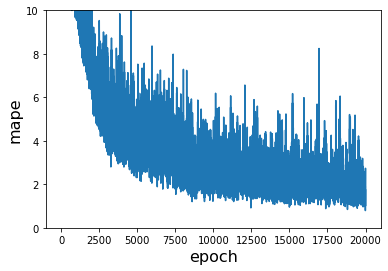

In [14]:
plt.plot(BestModel_temp.history['mape'])

plt.ylabel("mape", fontsize='16')
plt.xlabel("epoch", fontsize='16')
plt.ylim(0,10)

In [15]:
(model.predict(TrainData)-0.5)*dist_value+min_value

array([[0.00103422],
       [0.00133406],
       [0.00052586],
       [0.00076689],
       [0.00095826],
       [0.00102549],
       [0.00153701],
       [0.0010659 ],
       [0.00056064],
       [0.00132282],
       [0.0008553 ],
       [0.00066302],
       [0.00088051],
       [0.00103518],
       [0.00102486],
       [0.00111565],
       [0.00133112],
       [0.00056295],
       [0.00147255],
       [0.00093981],
       [0.00106355],
       [0.00118008],
       [0.00086131],
       [0.00125388],
       [0.00113305],
       [0.00075455],
       [0.00077162],
       [0.00120163],
       [0.00088623],
       [0.00060912],
       [0.00061627],
       [0.00100833],
       [0.00078172],
       [0.00146099],
       [0.00086738],
       [0.00084723],
       [0.00096728],
       [0.00069477],
       [0.00141289],
       [0.00121415],
       [0.00086854],
       [0.001229  ],
       [0.00112456],
       [0.00092587],
       [0.00083003],
       [0.00080281],
       [0.00101327],
       [0.000

In [16]:
type(TrainLabel_)

pandas.core.series.Series

In [17]:
ErrorTable = np.zeros((100,3))
ErrorTable[:,0] = TrainLabel_
for i in range(100):
    a = ((model.predict(TrainData)-0.5)*dist_value+min_value)[i]
    ErrorTable[i,1] = a
    ErrorTable[i,2] = ((TrainLabel_[i]-a)/TrainLabel_[i])*100

In [18]:
ErrorTable = pd.DataFrame(ErrorTable)
ErrorTable

,0,1,2
0,0.001040,0.001034,0.586198
1,0.001311,0.001334,-1.725734
2,0.000507,0.000526,-3.624137
3,0.000756,0.000767,-1.456998
4,0.000944,0.000958,-1.457239
...,...,...,...
95,0.000798,0.000832,-4.282157
96,0.001372,0.001388,-1.178970
97,0.000753,0.000803,-6.553169
98,0.000793,0.000803,-1.277046


In [21]:
np.mean(np.abs(ErrorTable.iloc[:,2]))

2.7015654807537794

In [19]:
ErrorTable.to_csv('D:/testoneblow/ANN_prediction2.0/sliced_Mm label/ErrorTable.csv')